In [3]:
from netCDF4 import Dataset, date2num
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers, metrics, optimizers, losses, regularizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy.stats import linregress
import os
import xarray as xr
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random

#### Data Preprocessing

##### Computing daily mean from hourly data and merging

In [1]:
## Case of specific humidity and horizontal components of wind
# Computing daily mean
input_folder="../input_data" # update with correct path
output_folder="../input_data" # update with correct path
files=os.listdir(input_folder)
for file in files:
    input_file=os.path.join(input_folder, file)
    ds=xr.open_dataset(input_file)
    print(f'Processing with the file {input_file}')
    daily_ds = ds.resample(valid_time='1D').mean()
    output_file=input_file.replace(".nc", "_daily_mean.nc")
    output_path=os.path.join(output_folder, output_file)
    daily_ds.to_netcdf(output_path)
    print(f'Finished with the file {file} and saved')
    
# Merging data
input_folder="../input_data" # update with correct path
output_folder="../input_data" # update with correct path
output_file ="merged_quv_output.nc"  # update with correct filename
output_path = os.path.join(output_folder, output_file)
files_to_merge=os.listdir(input_folder)
files_merged=[os.path.join(input_folder, f) for f in files_to_merge]
files_to_merge_test=sorted(files_merged)
datasets = [xr.open_dataset(file) for file in files_to_merge_test]
combined_dataset = xr.concat(datasets, dim='valid_time')
combined_dataset.to_netcdf(output_path)
print(f"Merged file saved as {output_file}")

##### Rewriting data to be able to compute Vertical Integrate Moisture Flux

In [11]:
start_date = "1984-12-01"
end_date = "2023-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq="D")
dates = dates[dates.month.isin([12])]

In [13]:
## Case of specific humidity and horizontal components of wind
data=xr.open_dataset('../input_data/merged_quv_output.nc')
data=data.where(data.valid_time.dt.month.isin([12]), drop=True)
q_data=data.q.values
u_data=data.u.values
v_data=data.v.values
lat_data=data.latitude.values
lon_data=data.longitude.values
#time_data=data.valid_time.values
lev_data=data.pressure_level.values

output_file = "../input_data/merged_quv_output_ok5.nc"

with Dataset(output_file, "w", format="NETCDF4") as nc_file:
    # Create dimensions
    nc_file.createDimension("time", len(dates)) 
    nc_file.createDimension("lev", len(lev_data))
    nc_file.createDimension("lat", len(lat_data))
    nc_file.createDimension("lon", len(lon_data))

    # Create coordinate variables
    times = nc_file.createVariable("time", "f8", ("time",))
    lev = nc_file.createVariable("lev", "f8", ("lev",))
    lat = nc_file.createVariable("lat", "f8", ("lat",))
    lon = nc_file.createVariable("lon", "f8", ("lon",))

    # Create variables
    q = nc_file.createVariable("q", "f8", ("time", "lev", "lat", "lon",))
    u = nc_file.createVariable("u", "f8", ("time", "lev", "lat", "lon",))
    v = nc_file.createVariable("v", "f8", ("time", "lev", "lat", "lon",))

    # Add attributes to coordinate variables
    times.units = "hours since 1984-01-01 00:00:00"
    times.calendar = "gregorian"
    lev.units = "hPa"
    lev.long_name = "Pressure level"
    lat.units = "degrees_north"
    lon.units = "degrees_east"
    lat.long_name = "Latitude"
    lon.long_name = "Longitude"
    
    # Add attributes to data variables
    u.units = "m/s"
    u.long_name = "Zonal wind component"
    v.units = "m/s"
    v.long_name = "Meridional wind component"
    q.units = "kg/kg"
    q.long_name = "Specific humidity"

    # Write data to coordinate variables
    times[:] = date2num(dates.to_pydatetime(), units=times.units, calendar=times.calendar)
    lev[:] = lev_data
    lat[:] = lat_data
    lon[:] = lon_data

    # Write data to data variables
    u[:, :, :, :] = u_data
    v[:, :, :, :] = v_data
    q[:, :, :, :] = q_data

print(f"NetCDF file '{output_file}' created successfully.")

NetCDF file '/users/fs1/flmouassom/Project2/data_used/merged_quv_output_ok5.nc' created successfully.


##### Extreme day selection

In [6]:
data=xr.open_dataset('../input_data/CA_1984-2023_daily_pr_masked.nc')
dat=data['pr'].values
dat_anom=(dat-dat.mean(axis=0))/dat.std(axis=0)
day=pd.DataFrame({'time':[0], 'nwet':[0], 'ndry':[0], 'nreg':[0]})
n_total=12233
for k in range(dat_anom.shape[0]):
    nwet=0
    ndry=0
    nreg=0
    for i in range(dat_anom.shape[1]):
        for j in range(dat_anom.shape[2]):
            if dat_anom[k, i, j]>=2:
                nwet+=1
            if dat_anom[k, i, j]<=-2:
                ndry+=1
            if -2<dat_anom[k, i, j]<2:
                nreg+=1
    df1=pd.DataFrame({'time':[data.time[k].values], 'nwet':[(nwet*100)/n_total], 'ndry':[(ndry*100)/n_total], 'nreg':[(nreg*100)/n_total]})
    day=pd.concat([day, df1])
day = day[day['time'] != 0]
day['label'] = (day['nwet'] >= 10).astype(int)
day.reset_index(drop=True, inplace=True)
day.to_csv('../processed_data/extreme_event_days.csv', sep=',')

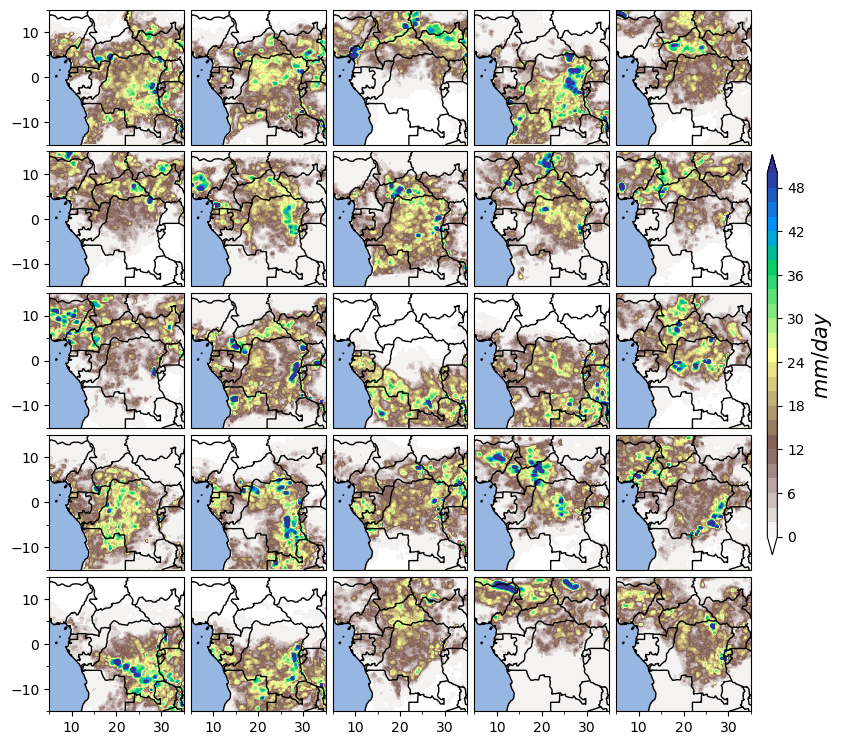

In [7]:
projection = ccrs.PlateCarree()
level=np.arange(0, 50.2, 2)
cmap='terrain_r'
fig = plt.figure(figsize=(10, 8))
df=pd.read_csv('../processed_data/extreme_event_days.csv')
df_reg=df[df['label']==1]
df_region=df_reg.sort_values(by='nwet', ascending=False)
df_region=np.array(pd.to_datetime(df_region['time']))
for k in range(25):
    ax = fig.add_subplot(5, 5, k+1, projection=projection)
    data_ex=data.where(data.time.isin([df_region[k]]), drop=True)
    mymap = ax.contourf(data.longitude, data.latitude, data_ex.pr[0, :, :], extend='both', cmap=cmap, levels=level)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.add_feature(cfeature.LAND.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    if k in [0, 5, 10, 15, 20]:
        ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
    if k in [20, 21, 22, 23, 24]:
        ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
plt.tight_layout(h_pad=+0.5, w_pad=-15, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.88, 0.3, 0.01, 0.5])
cbar = plt.colorbar(mymap, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'$mm/day$', rotation=90, fontsize=15, fontweight='bold')
plt.savefig('../Figure/Figure.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

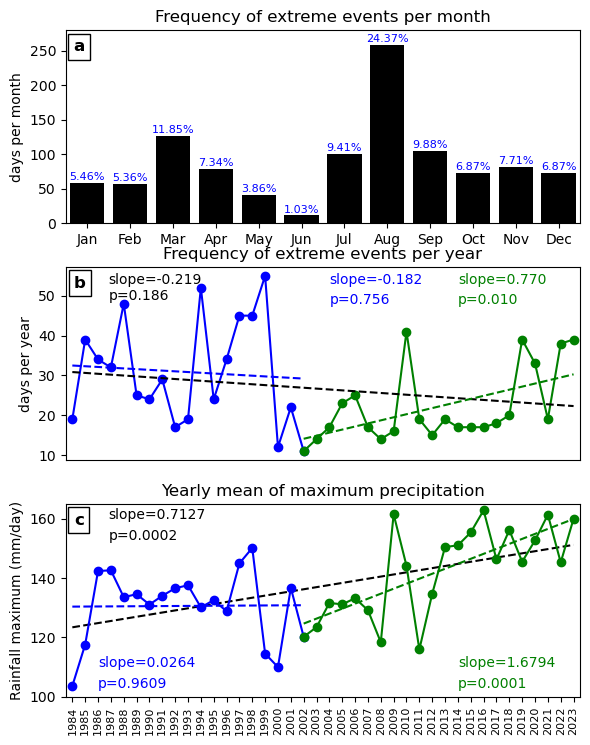

In [35]:
df=pd.read_csv('../processed_data/extreme_event_days.csv')
df_reg=df[df['label']==1]
df_region=df_reg.sort_values(by='nwet', ascending=False)
df_region=np.array(pd.to_datetime(df_region['time']))
data=xr.open_dataset('../input_data/CA_1984-2023_daily_pr_masked.nc')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
month_time=list(pd.to_datetime(df_reg['time']).dt.month)
year_time=list(pd.to_datetime(df_reg['time']).dt.year)
month=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year=[str(k) for k in np.arange(1984, 2024)]
years = np.arange(1984, 2024)
        
n_event_per_month=np.zeros(len(month))
for i in range(len(month)):
    n_event_per_month[i]=month_time.count(i+1)   
for i, valeur in enumerate(n_event_per_month):
    ax1.text(i, valeur + 1.5, f"{np.round((valeur/len(df_reg))*100, 2)}%", ha='center', va='bottom', color='blue', fontsize=8)
ax1.set_xlim(-0.5, 11.5)
ax1.set_ylim(0, 280)
ax1.set_ylabel('days per month')
ax1.bar(month, n_event_per_month, color='black')
ax1.set_title('Frequency of extreme events per month')
ax1.text(-0.2, 245, 'a', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)


n_event_per_year=np.zeros(len(year))
for i, y in enumerate([int(k) for k in year]):
    n_event_per_year[i]=year_time.count(y)

ax2.set_xlim(-0.5, 39.5)
ax2.set_ylabel('days per year')
ax2.set_xlabel('') 
ax2.set_xticks([])
ax2.plot(year[:-21], n_event_per_year[:-21], '-o', color='blue')
ax2.plot(year[18:], n_event_per_year[18:], '-o', color='green')
ax2.set_title('Frequency of extreme events per year')

slope, intercept, r_value, p_value, std_err = linregress(years, n_event_per_year)
ax2.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax2.text(2.8, 53, f'slope={slope:.3f}', color='black')
ax2.text(2.8, 49, f'p={p_value:.3f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-21], n_event_per_year[:-21])
ax2.plot(year[:-21], slope*years[:-21]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax2.text(20, 53, f'slope={slope:.3f}', color='blue')
ax2.text(20, 48, f'p={p_value:.3f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[18:], n_event_per_year[18:])
ax2.plot(year[18:], slope*years[18:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax2.text(30, 53, f'slope={slope:.3f}', color='green')
ax2.text(30, 48, f'p={p_value:.3f}', color='green')
ax2.text(0.6, 51.2, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)

day_max=pd.DataFrame({'time':[0], 'max':[0]})
for k in range(1063):
    data_ex=data.where(data.time.isin([df_region[k]]), drop=True)
    date=np.array(data_ex.time.dt.year)
    m=np.array(data_ex.pr[0, :, :].max())
    dff=pd.DataFrame({'time':date, 'max':[m]})
    day_max=pd.concat([day_max, dff])
day_max = day_max.loc[day_max['time'] != 0]
day_max=day_max.groupby('time').mean()
day_max=np.array(day_max['max'], dtype=float)

slope, intercept, r_value, p_value, std_err = linregress(years, day_max)
ax3.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax3.text(2.8, 160, f'slope={slope:.4f}', color='black')
ax3.text(2.8, 153, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-21], day_max[:-21])
ax3.plot(year[:-21], slope*years[:-21]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax3.text(2, 110, f'slope={slope:.4f}', color='blue')
ax3.text(2, 103, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[18:], day_max[18:])
ax3.plot(year[18:], slope*years[18:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax3.set_xlim(-0.5, 39.5)
ax3.set_ylim(100, 165)
ax3.set_ylabel('Rainfall maximum (mm/day)')
ax3.plot(year[:-21], day_max[:-21], '-o', color='blue')
ax3.plot(year[18:], day_max[18:], '-o', color='green')
ax3.text(30, 110, f'slope={slope:.4f}', color='green')
ax3.text(30, 103, f'p={p_value:.4f}', color='green')
ax3.set_title('Yearly mean of maximum precipitation')
ax3.text(0.5, 157, 'c', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)


plt.xticks(rotation=90, fontsize=8)
plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('/users/fs1/flmouassom/Project2/Figure/Figure2.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('/users/fs1/flmouassom/Project2/Figure/Figure2.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

#### Machine Learning Part

##### Function and Metrics

In [4]:
METRICS = [
    metrics.CategoricalAccuracy(name='accuracy'),
    metrics.Precision(class_id = 1, name='precision'),
    metrics.Recall(class_id = 1, name='recall'),
    metrics.AUC(curve='PR', num_thresholds=1000, name='pr_auc')
]

def class_weights(x):
    n_class = x.max() + 1
    csize = []
    for i in range(n_class):
        csize.append((x == i).sum())
    w = dict()
    for i in range(n_class):
        w[i] = max(csize)/(csize[i]*n_class)
    return(w)
    
def onehot(x):
    y = np.zeros((x.size, x.max()+1)) 
    y[np.arange(x.size),x] = 1
    
    return(y)

##### Data preparation

In [5]:
data_x=xr.open_dataset('/users/fs1/flmouassom/Project2/data_used/Vertical_Integrated_Moisture_convergence.nc')
data_y=pd.read_csv('/users/fs1/flmouassom/Project2/data_used/extreme_event_days.csv')
data_y['time'] = pd.to_datetime(data_y['time'], errors='coerce')
data_y=data_y.drop('Unnamed: 0', axis=1)
n_time=len(data_x.time.values)
n_lat=len(data_x.lat.values)
n_lon=len(data_x.lon.values)
x_data=data_x.VIMFC.values
x_data=(x_data-x_data.mean(axis=0))/x_data.std(axis=0)
x_data=x_data.reshape(n_time, n_lat, n_lon, 1).astype(np.float32)
y_data=np.array(data_y['label'])
y_data=y_data.astype(np.int32)
y_data_one_hot=onehot(y_data)
ind = np.arange(len(y_data))
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x_data, y_data_one_hot, ind, test_size=0.20, random_state=42, 
                                                                         shuffle = True, stratify = y_data_one_hot)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(11688, 121, 121, 1) (2922, 121, 121, 1)
(11688, 2) (2922, 2)


##### Model building to test best hyper parameter

In [6]:
def build_model_test(lr, conv_filters, dense_neurons, dense_layers, activity_reg, dropout_rate, input_channels=1):
    model = models.Sequential()
    model.add(layers.Input(shape=(121, 121, input_channels)))
    
    model.add(layers.Conv2D(conv_filters, (3, 3), activity_regularizer=regularizers.l2(activity_reg)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Conv2D(conv_filters, (3, 3), activity_regularizer=regularizers.l2(activity_reg)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Flatten())
    
    for _ in range(dense_layers):
        model.add(layers.Dense(dense_neurons, activity_regularizer=regularizers.l2(activity_reg)))
        model.add(layers.Activation('relu'))
    
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(loss=losses.CategoricalCrossentropy(), 
                  optimizer=optimizers.Adam(learning_rate=lr), 
                  metrics=METRICS)
    return model

##### StratifiedKFold to select the best lr and batch_size

In [7]:
y_labels = np.argmax(y_data_one_hot, axis=1)

param_grid = {
    'lr': [0.0001, 0.0005,  0.001, 0.005, 0.01],
    'batch_size': [128, 256, 512, 1024, 2048]
}

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_params_recall = None
best_params_prauc = None
best_recall = 0
best_prauc = 0

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        print(f"\nTesting: lr={lr}, batch_size={batch_size}")
        
        recalls = []
        pr_aucs = []
        
        for train_idx, test_idx in skf.split(x_data, y_labels):
            X_train, X_test = x_data[train_idx], x_data[test_idx]
            y_train, y_test = y_data_one_hot[train_idx], y_data_one_hot[test_idx]
            y_weight = y_labels[train_idx]
            
            model_test = build_model_test(lr=lr, conv_filters=16, dense_neurons=16, dense_layers=1, activity_reg=0.001, dropout_rate=0.2)
            class_weigh = class_weights(y_weight.astype('int'))
            model_test.fit(X_train, y_train, epochs=15, batch_size=batch_size, class_weight=class_weigh, verbose=0)
            scores = model_test.evaluate(X_test, y_test, verbose=0)
            recalls.append(scores[3])
            pr_aucs.append(scores[4]) 
        
        mean_recall = np.mean(recalls)
        mean_prauc = np.mean(pr_aucs)
        print(f"Mean Recall: {mean_recall:.4f}")
        print(f"Mean PR AUC: {mean_prauc:.4f}")
        
        if mean_recall > best_recall:
            best_recall = mean_recall
            best_params_recall = {'lr': lr, 'batch_size': batch_size}
        if mean_prauc > best_prauc:
            best_prauc = mean_prauc
            best_params_prauc = {'lr': lr, 'batch_size': batch_size}

print("\nBest Hyperparameters for Stage:")
print(f" According to the best Recall :{best_recall} the best parameters is")
print(best_params_recall)
print(f" According to the best PR AUC :{best_prauc} the best parameters is")
print(best_params_prauc)


Testing: lr=0.0001, batch_size=128
Mean Recall: 0.6142
Mean PR AUC: 0.9867

Testing: lr=0.0001, batch_size=256
Mean Recall: 0.7791
Mean PR AUC: 0.9755

Testing: lr=0.0001, batch_size=512
Mean Recall: 0.8871
Mean PR AUC: 0.9451

Testing: lr=0.0001, batch_size=1024
Mean Recall: 0.8825
Mean PR AUC: 0.9014

Testing: lr=0.0001, batch_size=2048
Mean Recall: 0.9341
Mean PR AUC: 0.8592

Testing: lr=0.0005, batch_size=128
Mean Recall: 0.8646
Mean PR AUC: 0.9545

Testing: lr=0.0005, batch_size=256
Mean Recall: 0.7329
Mean PR AUC: 0.9785

Testing: lr=0.0005, batch_size=512
Mean Recall: 0.6865
Mean PR AUC: 0.9805

Testing: lr=0.0005, batch_size=1024
Mean Recall: 0.7410
Mean PR AUC: 0.9609

Testing: lr=0.0005, batch_size=2048
Mean Recall: 0.7329
Mean PR AUC: 0.9655

Testing: lr=0.001, batch_size=128
Mean Recall: 0.9304
Mean PR AUC: 0.9534

Testing: lr=0.001, batch_size=256
Mean Recall: 0.8626
Mean PR AUC: 0.9697

Testing: lr=0.001, batch_size=512
Mean Recall: 0.7526
Mean PR AUC: 0.9679

Testing: l

##### StratifiedKFold to select the best conv_filters, conv_filters and dense_layers

In [9]:
y_labels = np.argmax(y_data_one_hot, axis=1)

param_grid = {
    'conv_filters': [8, 16, 32],
    'dense_neurons': [8, 16, 32],
    'dense_layers': [1, 2, 3]
}

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_params_recall = None
best_params_prauc = None
best_recall = 0
best_prauc = 0

for conv_filter in param_grid['conv_filters']:
    for dense_neuron in param_grid['dense_neurons']:
        for dense_layer in param_grid['dense_layers']:
            print(f"\nTesting: conv_filters={conv_filter}, dense_neurons={dense_neuron}, dense_layers={dense_layer}")
            
            recalls = []
            pr_aucs = []
            
            for train_idx, test_idx in skf.split(x_data, y_labels):
                X_train, X_test = x_data[train_idx], x_data[test_idx]
                y_train, y_test = y_data_one_hot[train_idx], y_data_one_hot[test_idx]
                y_weight = y_labels[train_idx]
                
                model_test = build_model_test(lr=0.0001, conv_filters=conv_filter, dense_neurons=dense_neuron, dense_layers=dense_layer, activity_reg=0.001, dropout_rate=0.2)
                class_weigh = class_weights(y_weight.astype('int'))
                model_test.fit(X_train, y_train, epochs=15, batch_size=2048, class_weight=class_weigh, verbose=0)
                scores = model_test.evaluate(X_test, y_test, verbose=0)
                recalls.append(scores[3])
                pr_aucs.append(scores[4]) 
            
            mean_recall = np.mean(recalls)
            mean_prauc = np.mean(pr_aucs)
            print(f"Mean Recall: {mean_recall:.4f}")
            print(f"Mean PR AUC: {mean_prauc:.4f}")
            
            if mean_recall > best_recall:
                best_recall = mean_recall
                best_params_recall = {'conv_filters': conv_filter, 'dense_neurons': dense_neuron, 'dense_layers': dense_layer}
            if mean_prauc > best_prauc:
                best_prauc = mean_prauc
                best_params_prauc = {'conv_filters': conv_filter, 'dense_neurons': dense_neuron, 'dense_layers': dense_layer}

print("\nBest Hyperparameters for Stage:")
print(f" According to the best Recall :{best_recall} the best parameters is")
print(best_params_recall)
print(f" According to the best PR AUC :{best_prauc} the best parameters is")
print(best_params_prauc)


Testing: conv_filters=8, dense_neurons=8, dense_layers=1
Mean Recall: 0.8976
Mean PR AUC: 0.6350

Testing: conv_filters=8, dense_neurons=8, dense_layers=2
Mean Recall: 0.8722
Mean PR AUC: 0.8044

Testing: conv_filters=8, dense_neurons=8, dense_layers=3
Mean Recall: 0.8514
Mean PR AUC: 0.7756

Testing: conv_filters=8, dense_neurons=16, dense_layers=1
Mean Recall: 0.8984
Mean PR AUC: 0.8807

Testing: conv_filters=8, dense_neurons=16, dense_layers=2
Mean Recall: 0.8467
Mean PR AUC: 0.8455

Testing: conv_filters=8, dense_neurons=16, dense_layers=3
Mean Recall: 0.8326
Mean PR AUC: 0.8662

Testing: conv_filters=8, dense_neurons=32, dense_layers=1
Mean Recall: 0.8682
Mean PR AUC: 0.8550

Testing: conv_filters=8, dense_neurons=32, dense_layers=2
Mean Recall: 0.8336
Mean PR AUC: 0.8416

Testing: conv_filters=8, dense_neurons=32, dense_layers=3
Mean Recall: 0.9059
Mean PR AUC: 0.8154

Testing: conv_filters=16, dense_neurons=8, dense_layers=1
Mean Recall: 0.9201
Mean PR AUC: 0.8490

Testing: con

##### StratifiedKFold to select the best activity_reg and dropout_rate

In [11]:
y_labels = np.argmax(y_data_one_hot, axis=1)

param_grid = {
    'activity_regs': [0.0001, 0.0005,  0.001, 0.005, 0.01, 0.05, 0.1],
    'dropout_rates': [0.1, 0.2, 0.3, 0.4],
}

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_params_recall = None
best_params_prauc = None
best_recall = 0
best_prauc = 0

for activity_reg in param_grid['activity_regs']:
    for dropout_rate in param_grid['dropout_rates']:
        print(f"\nTesting: activity_regs={activity_reg}, dropout_rates={dropout_rate}")
        
        recalls = []
        pr_aucs = []
        
        for train_idx, test_idx in skf.split(x_data, y_labels):
            X_train, X_test = x_data[train_idx], x_data[test_idx]
            y_train, y_test = y_data_one_hot[train_idx], y_data_one_hot[test_idx]
            y_weight = y_labels[train_idx]
            
            model_test = build_model_test(lr=0.0001, conv_filters=32, dense_neurons=32, dense_layers=1, activity_reg=activity_reg, dropout_rate=dropout_rate)
            class_weigh = class_weights(y_weight.astype('int'))
            model_test.fit(X_train, y_train, epochs=15, batch_size=2048, class_weight=class_weigh, verbose=0)
            scores = model_test.evaluate(X_test, y_test, verbose=0)
            recalls.append(scores[3])
            pr_aucs.append(scores[4]) 
        
        mean_recall = np.mean(recalls)
        mean_prauc = np.mean(pr_aucs)
        print(f"Mean Recall: {mean_recall:.4f}")
        print(f"Mean PR AUC: {mean_prauc:.4f}")
        
        if mean_recall > best_recall:
            best_recall = mean_recall
            best_params_recall = {'activity_regs': activity_reg, 'dropout_rates': dropout_rate}
        if mean_prauc > best_prauc:
            best_prauc = mean_prauc
            best_params_prauc = {'activity_regs': activity_reg, 'dropout_rates': dropout_rate}

print("\nBest Hyperparameters for Stage:")
print(f" According to the best Recall :{best_recall} the best parameters is")
print(best_params_recall)
print(f" According to the best PR AUC :{best_prauc} the best parameters is")
print(best_params_prauc)


Testing: activity_regs=0.0001, dropout_rates=0.1
Mean Recall: 0.8495
Mean PR AUC: 0.9678

Testing: activity_regs=0.0001, dropout_rates=0.2
Mean Recall: 0.9351
Mean PR AUC: 0.9138

Testing: activity_regs=0.0001, dropout_rates=0.3
Mean Recall: 0.8579
Mean PR AUC: 0.9637

Testing: activity_regs=0.0001, dropout_rates=0.4
Mean Recall: 0.8928
Mean PR AUC: 0.9220

Testing: activity_regs=0.0005, dropout_rates=0.1
Mean Recall: 0.8985
Mean PR AUC: 0.9307

Testing: activity_regs=0.0005, dropout_rates=0.2
Mean Recall: 0.8561
Mean PR AUC: 0.9621

Testing: activity_regs=0.0005, dropout_rates=0.3
Mean Recall: 0.9031
Mean PR AUC: 0.9373

Testing: activity_regs=0.0005, dropout_rates=0.4
Mean Recall: 0.9059
Mean PR AUC: 0.9026

Testing: activity_regs=0.001, dropout_rates=0.1
Mean Recall: 0.9182
Mean PR AUC: 0.9407

Testing: activity_regs=0.001, dropout_rates=0.2
Mean Recall: 0.8626
Mean PR AUC: 0.9629

Testing: activity_regs=0.001, dropout_rates=0.3
Mean Recall: 0.8900
Mean PR AUC: 0.9267

Testing: act

##### Model building best model

In [40]:
def build_model(lr=0.0001, conv_filters = 16, dense_neurons =32, dense_layers = 1, activity_reg = 0.0001, dropout_rate = 0.2, input_channels = 1):

    model = models.Sequential() 
    model.add(layers.Input(shape=(121, 121, input_channels))) 
    
    model.add(layers.Conv2D(conv_filters, (3,3), activity_regularizer=regularizers.l2(activity_reg))) 
    model.add(layers.Activation('relu')) 
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout_rate))
                            
    model.add(layers.Conv2D(conv_filters, (3,3), activity_regularizer=regularizers.l2(activity_reg))) 
    model.add(layers.Activation('relu')) 
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(dropout_rate))
                            
    model.add(layers.Flatten()) 
    
    for i in range(dense_layers):
        model.add(layers.Dense(dense_neurons, activity_regularizer=regularizers.l2(activity_reg)))
        model.add(layers.Activation('relu'))
     
    model.add(layers.Dense(2, activation='softmax')) 
    
    model.compile(loss=losses.CategoricalCrossentropy(), 
                  optimizer=optimizers.Adam(learning_rate = lr), 
                  metrics=METRICS)
    return(model)

##### Model training

In [41]:
y_labels = np.argmax(y_data_one_hot, axis=1)
y_weight = y_labels[ind_train]
class_weigh = class_weights(y_weight.astype('int'))
model = build_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 119, 119, 16)      160       
                                                                 
 activation_12 (Activation)  (None, 119, 119, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 59, 59, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 57, 57, 16)        2320      
                                                                 
 activation_13 (Activation)  (None, 57, 57, 16)        0         
                                                      

In [42]:
history = model.fit(x_train, y_train, batch_size = 2048, epochs = 100, class_weight = class_weigh, 
                    validation_data = (x_test, y_test), callbacks = [callback])

Epoch 1/100
6/6 [==============================] - 8s 1s/step - loss: 3.9642 - accuracy: 0.7985 - precision: 0.2307 - recall: 0.7580 - pr_auc: 0.9060 - val_loss: 3.8801 - val_accuracy: 0.4685 - val_precision: 0.1127 - val_recall: 0.9155 - val_pr_auc: 0.4545
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 3.7463 - accuracy: 0.5799 - precision: 0.1300 - recall: 0.8388 - pr_auc: 0.5795 - val_loss: 3.5688 - val_accuracy: 0.8368 - val_precision: 0.2591 - val_recall: 0.6667 - val_pr_auc: 0.9055
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 3.5752 - accuracy: 0.7406 - precision: 0.1959 - recall: 0.8271 - pr_auc: 0.7800 - val_loss: 3.4620 - val_accuracy: 0.7823 - val_precision: 0.2319 - val_recall: 0.8592 - val_pr_auc: 0.8525
Epoch 4/100
6/6 [==============================] - 7s 1s/step - loss: 3.4162 - accuracy: 0.7888 - precision: 0.2361 - recall: 0.8518 - pr_auc: 0.8492 - val_loss: 3.2846 - val_accuracy: 0.8313 - val_precision: 0.2792 - val_reca

In [44]:
# model.save_weights('/users/fs1/flmouassom/Project2/Code/trained_weight.h5')
model.save_weights('/users/fs1/flmouassom/Project2/Code/trained_weight1.h5')

In [45]:
test_loss, test_accuracy, test_precision, test_recall, test_pr_auc=model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")
print(f"Test AUC: {test_pr_auc * 100:.2f}%")

92/92 - 0s - loss: 0.7516 - accuracy: 0.9466 - precision: 0.6000 - recall: 0.8028 - pr_auc: 0.9898 - 406ms/epoch - 4ms/step
Test Accuracy: 94.66%
Test Precision: 60.00%
Test Recall: 80.28%
Test AUC: 98.98%


In [46]:
class_predictions = model.predict(x_data)

457/457 [==============================] - 2s 4ms/step


In [47]:
history_df = pd.DataFrame(history.history) 
history_df.to_csv('/users/fs1/flmouassom/Project2/data_used/model_metrics.csv')
date=data_x.time.values
predict_df = pd.DataFrame(class_predictions)
predict_df = predict_df.rename(columns = {0: 'prob_0', 1: 'prob_1'})
predict_df['predicted_class'] = np.argmax(class_predictions, axis = 1)
predict_df['set'] = 'train'
predict_df.loc[ind_test, 'set'] = 'test'
predict_df['true_y'] = y_data
predict_df.insert(0, 'date', date)
predict_df.to_csv('/users/fs1/flmouassom/Project2/data_used/model_predictions.csv')

In [55]:
evaluation=model.evaluate(x_data, y_data_one_hot, verbose=2)
evaluation
ev=pd.DataFrame({'loss':[evaluation[0]], 'accuracy': [evaluation[1]], 'precision': [evaluation[2]], 'recall':[evaluation[3]], 'pr_auc': [evaluation[4]],'lr':[0.0001], 'activity_reg':[0.0001], 'dropout_rate':[0.2]})
ev.to_csv('/users/fs1/flmouassom/Project2/data_used/model_evaluation.csv')

457/457 - 2s - loss: 0.7278 - accuracy: 0.9612 - precision: 0.6627 - recall: 0.9501 - pr_auc: 0.9938 - 2s/epoch - 4ms/step


In [56]:
ev.to_csv('/users/fs1/flmouassom/Project2/data_used/model_evaluation1.csv')

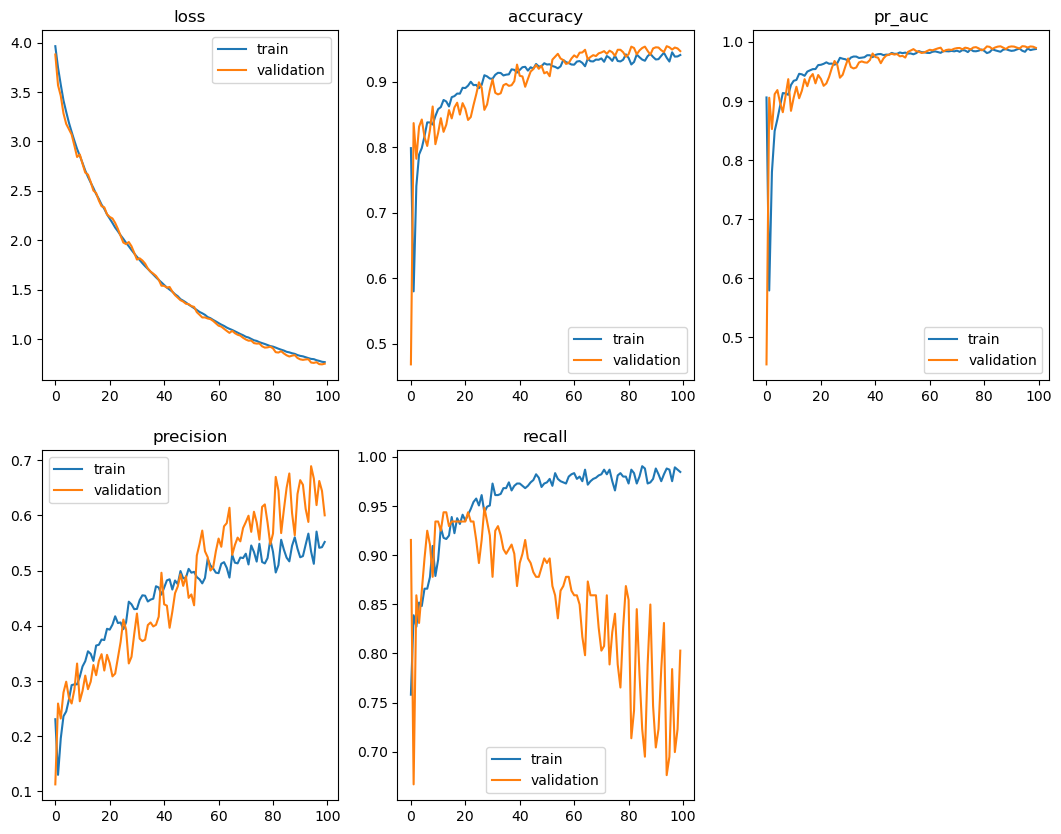

In [48]:
fig = plt.figure(figsize=(13, 10))
df=pd.read_csv('/users/fs1/flmouassom/Project2/data_used/model_metrics.csv')
metrics=['loss', 'accuracy', 'pr_auc', 'precision', 'recall']
val_metrics=['val_loss', 'val_accuracy', 'val_pr_auc', 'val_precision', 'val_recall']
for k in range(len(metrics)):
    metric=df[metrics[k]]
    val_metric=df[val_metrics[k]]
    ax = fig.add_subplot(2, 3, k+1)
    ax.plot(metric, label='train')
    ax.plot(val_metric, label='validation')
    ax.set_title(metrics[k])
    ax.legend()

In [6]:
dff=pd.read_csv('/users/fs1/flmouassom/Project2/data_used/model_predictions.csv')
len(dff[(dff['predicted_class']==0) & (dff['true_y']==1)])

53

In [6]:
fd=xr.open_dataset('/users/fs1/flmouassom/Project2/data_used/v_grad_q_non-epmfp_days.nc')
#fd_month=np.zeros((12, 13, 121, 121))
fd=fd.where(fd.time.dt.month==1, drop=True)
fd

<xarray.Dataset>
Dimensions:   (time: 1172, lev: 13, lat: 121, lon: 121)
Coordinates:
  * time      (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2023-01-31
  * lon       (lon) float32 5.0 5.25 5.5 5.75 6.0 ... 34.0 34.25 34.5 34.75 35.0
  * lat       (lat) float32 -15.0 -14.75 -14.5 -14.25 ... 14.25 14.5 14.75 15.0
  * lev       (lev) float32 1e+03 950.0 900.0 850.0 ... 550.0 500.0 400.0 300.0
Data variables:
    v_grad_q  (time, lev, lat, lon) float32 -0.0003087 2.955e-05 ... 1.528e-06
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jan 07 12:11:51 2025: cdo mergetime v_grad_q_0.nc v_gra...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [9]:
(53*100)/1063

4.985888993414863

In [39]:
model.load_weights('/users/fs1/flmouassom/Project2/Code/trained_weight.h5')

ValueError: Cannot assign value to variable ' conv2d_6/kernel:0': Shape mismatch.The variable shape (3, 3, 1, 16), and the assigned value shape (32, 1, 3, 3) are incompatible.

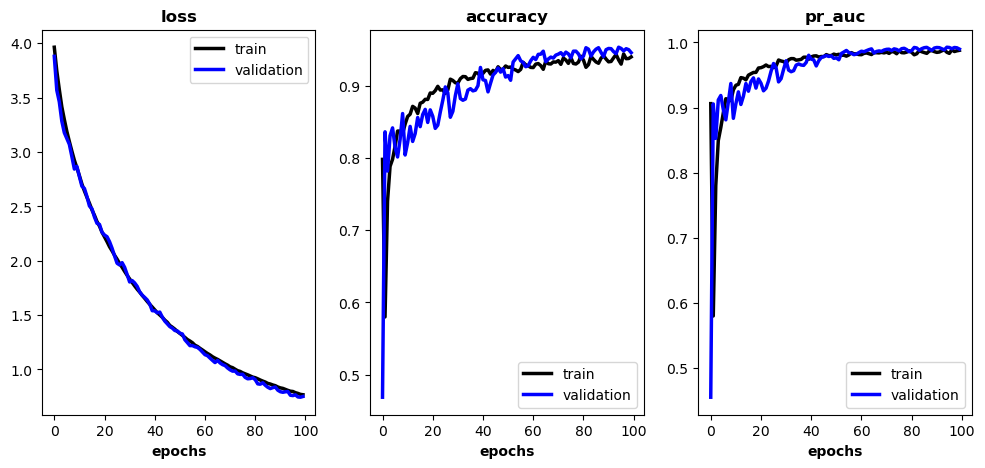

In [33]:
fig = plt.figure(figsize=(12, 5))
df=pd.read_csv('/users/fs1/flmouassom/Project2/data_used/model_metrics.csv')
title=['loss', 'accuracy', 'recall']
metrics=['loss', 'accuracy', 'pr_auc']
val_metrics=['val_loss', 'val_accuracy', 'val_pr_auc']
for k in range(3):
    metric=df[metrics[k]]
    val_metric=df[val_metrics[k]]
    ax = fig.add_subplot(1, 3, k+1)
    ax.plot(metric, 'k', linewidth=2.5, label='train')
    ax.plot(val_metric, 'b', linewidth=2.5,   label='validation')
    ax.set_title(metrics[k], fontweight='bold')
    ax.set_xlabel('epochs', fontweight='bold')
    ax.legend()